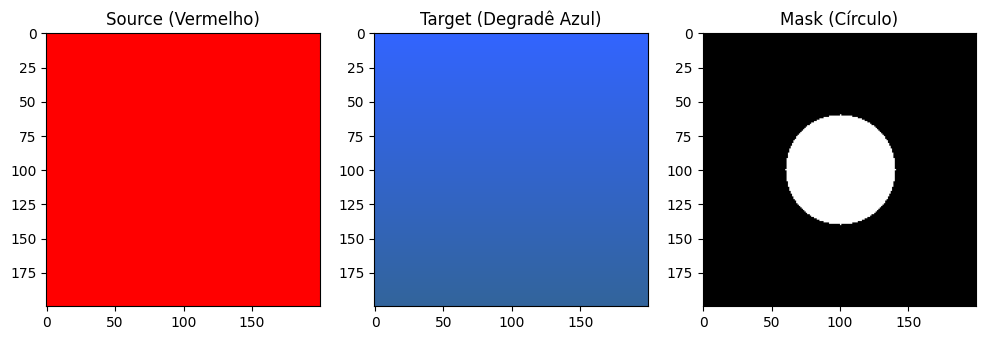

Iniciando Poisson Blending...
Resolvendo canal 0...
Resolvendo canal 1...
Resolvendo canal 2...
Pronto!


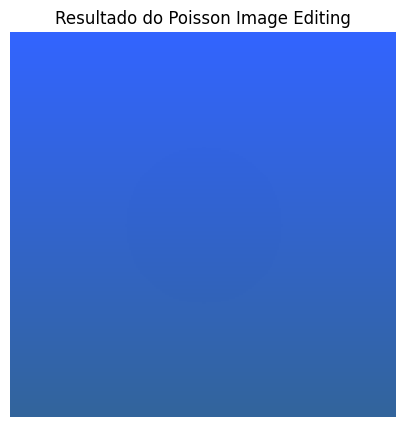

In [5]:
import numpy as np
import scipy.sparse as sp
import scipy.sparse.linalg
import cv2
import matplotlib.pyplot as plt

def laplacian_matrix(n, m):
    """
    Gera a matriz Laplaciana discreta para uma grade n x m.
    (Essa função é uma forma otimizada daquela que fizemos com loop)
    """
    mat_D2 = sp.lil_matrix((n, n))
    mat_D2.setdiag(-1, -1)
    mat_D2.setdiag(4)
    mat_D2.setdiag(-1, 1)

    mat_A = sp.block_diag([mat_D2] * m).tolil()

    mat_A.setdiag(-1, 1*n)
    mat_A.setdiag(-1, -1*n)

    return mat_A

def poisson_blend_channel(source, target, mask):
    """
    Realiza o Poisson Blending para UM canal de cor.
    CORRIGIDO: Evita conflito de nome entre vetor solução 'x' e coordenada 'x'.
    """
    # Índices dos pixels que vamos resolver
    mask_flat = mask.flatten()
    indices_dentro = np.nonzero(mask_flat)[0]

    # Calcular o Laplaciano da Fonte
    laplacian_kernel = np.array([[0, -1, 0],
                                 [-1, 4, -1],
                                 [0, -1, 0]])
    source_laplacian = cv2.filter2D(source, -1, laplacian_kernel)

    h, w = source.shape

    # Mapeamento: coordenadas (y,x) -> índice k
    coords = np.argwhere(mask > 0)
    n_pixels = len(coords)
    pixel_map = {tuple(p): i for i, p in enumerate(coords)}

    # Construção de Ax = b
    A = sp.lil_matrix((n_pixels, n_pixels))
    b = np.zeros(n_pixels)

    for k, (y, x_coord) in enumerate(coords): # Mudei aqui para x_coord
        A[k, k] = 4

        # O valor do gradiente desejado
        b[k] = source_laplacian[y, x_coord]

        vizinhos = [(y-1, x_coord), (y+1, x_coord), (y, x_coord-1), (y, x_coord+1)]
        for vy, vx in vizinhos:
            if 0 <= vy < h and 0 <= vx < w:
                if mask[vy, vx]:
                    # Vizinho é incógnita (lado esquerdo)
                    viz_idx = pixel_map[(vy, vx)]
                    A[k, viz_idx] = -1
                else:
                    # Vizinho é Borda/Target (lado direito)
                    b[k] += target[vy, vx]

    # Resolver o Sistema Linear
    # Mudei o nome de 'x' para 'x_solution' para não conflitar!
    x_solution = scipy.sparse.linalg.spsolve(A.tocsr(), b)

    # Colocar os pixels resolvidos de volta na imagem
    result = target.copy()
    for k, (y, x_coord) in enumerate(coords):
        # Agora usamos x_solution para pegar o valor calculado
        val = np.clip(x_solution[k], 0, 255)
        result[y, x_coord] = val

    return result
# --- FLUXO PRINCIPAL (Pipeline) ---

# --- GERADOR DE IMAGENS DE TESTE (Para não precisar de arquivos externos) ---

# 1. TARGET (O Fundo): Um degradê azul suave (200x200)
# (Imagine que é um céu)
H, W = 200, 200
dst = np.zeros((H, W, 3), dtype=float)
for i in range(H):
    # Degradê vertical: Vai clareando o azul
    dst[i, :, 0] = 255 - i/2  # Canal B (Blue)
    dst[i, :, 1] = 100        # Canal G (Green)
    dst[i, :, 2] = 50         # Canal R (Red)

# 2. SOURCE (O Objeto): Um quadrado vermelho chapado
# (Vamos ver se o Poisson consegue adaptar a cor dele ao fundo)
src = np.zeros((H, W, 3), dtype=float)
src[:, :, 2] = 255  # Tudo Vermelho (Canal R)

# 3. MASK (A Máscara): Um círculo branco no meio
# Onde for branco, copiamos o source. Onde for preto, mantemos o target.
mask = np.zeros((H, W), dtype=float)
center_y, center_x = H//2, W//2
radius = 40

y, x = np.ogrid[:H, :W]
mask_area = (x - center_x)**2 + (y - center_y)**2 <= radius**2
mask[mask_area] = 1  # 1 = Dentro do círculo (Região Omega)

# Visualizar o que criamos antes de rodar o algoritmo
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
ax[0].imshow(src.astype(np.uint8)[:,:,::-1]); ax[0].set_title("Source (Vermelho)")
ax[1].imshow(dst.astype(np.uint8)[:,:,::-1]); ax[1].set_title("Target (Degradê Azul)")
ax[2].imshow(mask, cmap='gray'); ax[2].set_title("Mask (Círculo)")
plt.show()

# 2. Processar canal por canal (R, G, B)
result_img = np.zeros_like(dst)
print("Iniciando Poisson Blending...")

# Loop pelos 3 canais (Blue, Green, Red)
for channel in range(3):
    print(f"Resolvendo canal {channel}...")
    result_img[:, :, channel] = poisson_blend_channel(
        src[:, :, channel],
        dst[:, :, channel],
        mask
    )

print("Pronto!")

# 3. Mostrar Resultado
# Converter de volta para uint8 para exibir
result_final = result_img.astype(np.uint8)

plt.figure(figsize=(10, 5))
plt.imshow(cv2.cvtColor(result_final, cv2.COLOR_BGR2RGB))
plt.title("Resultado do Poisson Image Editing")
plt.axis('off')
plt.show()